# MFA

## Definition of the system

In [43]:
import flodym as fd

dimension_definitions = [
    fd.DimensionDefinition(letter="s", name="substance", dtype=str),
]

In [44]:
process_names = [
    "sysenv",
    "dewatering",
    "soil application",
    "storage",
]

In [45]:
parameter_definitions = [
    fd.ParameterDefinition(name="dewatering", dim_letters=("s",)),
    fd.ParameterDefinition(name="composition", dim_letters=("s",)),
]

In [46]:
flow_definitions = [
    fd.FlowDefinition(from_process_name="sysenv", to_process_name="dewatering", dim_letters=("s",)),
    fd.FlowDefinition(from_process_name="dewatering", to_process_name="soil application", dim_letters=("s",)),
    fd.FlowDefinition(from_process_name="dewatering", to_process_name="storage", dim_letters=("s",)),
    fd.FlowDefinition(from_process_name="soil application", to_process_name="sysenv", dim_letters=("s",)),
    fd.FlowDefinition(from_process_name="storage", to_process_name="sysenv", dim_letters=("s",)),
]

In [47]:
stock_definitions = [
        fd.StockDefinition(
        name="dummy",
        dim_letters=("s",),
        time_letter="s",
        subclass=fd.SimpleFlowDrivenStock,
    ),
]

In [48]:
mfa_definition = fd.MFADefinition(
    dimensions=dimension_definitions,
    parameters=parameter_definitions,
    processes=process_names,
    flows=flow_definitions,
    stocks=stock_definitions,
)

## Data source

In [49]:
dimension_files = {
    "substance": "datamfa_manure/dimension_substance.csv",
}

In [50]:
parameter_files = {
    "dewatering": "datamfa_manure/parameter_dewatering.csv",
    "composition": "datamfa_manure/parameter_composition.csv"
}

## Compute MFA

In [51]:
class SimpleMFA(fd.MFASystem):
    def compute(self):

        # dewatering flows
        self.flows["sysenv => dewatering"][...] = self.parameters["composition"]
        self.flows["dewatering => soil application"][...] = self.flows["sysenv => dewatering"] * self.parameters["dewatering"]
        self.flows["dewatering => storage"][...] = self.flows["sysenv => dewatering"] * (1-self.parameters["dewatering"])

        # use stock
        #self.stocks["use"].inflow[...] = self.flows["manufacturing => use"]
        #self.stocks["use"].lifetime_model.set_prms(
            #mean=self.parameters["product lifetimes"],
            #std=0.5*self.parameters["product lifetimes"],
        #)
        #self.stocks["use"].compute()

        # end-of-life  flow
        self.flows["soil application => sysenv"][...] = self.flows["dewatering => soil application"]
        self.flows["storage => sysenv"][...] = self.flows["dewatering => storage"]

        # waste stock
        #self.stocks["waste"].inflow[...] = self.flows["use => waste"][...]
        #self.stocks["waste"].compute()

In [52]:
mfa_project = SimpleMFA.from_csv(
    definition=mfa_definition,
    dimension_files=dimension_files,
    parameter_files=parameter_files,
)

In [53]:
mfa_project.compute()

## Graphs

In [54]:
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)

mfa_project.check_mass_balance()

INFO:root:Checking mass balance of SimpleMFA object...
INFO:root:Success - Mass balance is consistent!


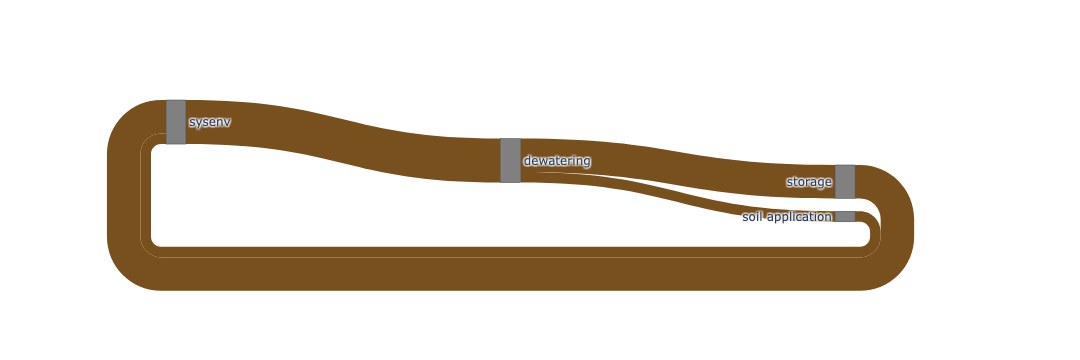

In [55]:
import flodym.export as fde

fig = fde.PlotlySankeyPlotter(mfa=mfa_project, exclude_processes=[], flow_color_dict = {"default":"rgb(120,80,30)"}).plot()
fig.show()

In [56]:
for key, value in mfa_project.flows.items():
    print(key)
    print("\t", value.from_process, value.values)

sysenv => dewatering
	 name='sysenv' id=0 [100. 900.]
dewatering => soil application
	 name='dewatering' id=1 [ 60. 180.]
dewatering => storage
	 name='dewatering' id=1 [ 40. 720.]
soil application => sysenv
	 name='soil application' id=2 [ 60. 180.]
storage => sysenv
	 name='storage' id=3 [ 40. 720.]


In [68]:
for k, p in mfa_project.processes.items():
    pass

In [69]:
mfa_project.processes

{'sysenv': Process(name='sysenv', id=0),
 'dewatering': Process(name='dewatering', id=1),
 'soil application': Process(name='soil application', id=2),
 'storage': Process(name='storage', id=3)}

In [58]:
value.values

array([ 40., 720.])

In [61]:
mfa_project.dims

DimensionSet(dim_list=[Dimension(name='substance', letter='s', items=['Dry matter', 'Water'], dtype=<class 'str'>)])

In [59]:
mfa_project.dims.dim_list[0].items

['Dry matter', 'Water']

# Automated Brightway `Database` creation via `wurst`

We can take the MFA system as our ground truth, and use it to construct a Brightway database. We start with these assumptions:

- `flodym` `Flows` are products _and_ edge amounts
- `flodym` `Processes` are processes

In [62]:
import bw2data as bd
import wurst as w

14:59:05+0100 [warning  ] Can't import `SimaProBlockCSVImporter` - please install `bw2io` with `pip install bw2io[multifunctional]` or install `multifunctional` and `bw_simapro_csv` manually.


In [150]:
def get_processes(
    mfa: fd.MFASystem, 
    database_name: str,
    sysenv_name: str = "sysenv",
    specific_metadata: dict | None = None,
    generic_metadata: dict | None = None,
) -> list[dict]:
    """Return a list of Brightway process nodes. The node names and codes are taken from the MFA data.
    
    You can pass additional process-specific metadata in `specific_metadata`; it should have the form:
    
        {<process name>: {<additional metadata>}}

    You can also pass generic metadata which will be applied to all processes in `generic_metadata`. It's
    your resposibility to make sure this data is reasonable.

    `generic_metadata` is applied before `specific_metadata`, and will therefore be overwritten if there is 
    a conflict.
    """
    processes = []

    for name, obj in mfa.processes.items():
        if name == sysenv_name:
            # System boundaries are not explicit in LCA to get a square matrix
            continue
        data = {
            "name": obj.name,
            "flodym_id": obj.id,
            "code": obj.name,
            "database": database_name,
            "type": bd.labels.process_node_default,
            "exchanges": [],
        }
        if generic_metadata:
            data.update(generic_metadata)
        if specific_metadata and name in specific_metadata:
            data.update(specific_metadata[name])
        processes.append(data)
    return processes

In [151]:
processes = get_processes(
    mfa_project, 
    "💩",
    specific_metadata={"soil application": {"stinky": True}}, 
    generic_metadata={"location": "FR"}
)
processes

[{'name': 'dewatering',
  'flodym_id': 1,
  'code': 'dewatering',
  'database': '💩',
  'type': 'process',
  'exchanges': [],
  'location': 'FR'},
 {'name': 'soil application',
  'flodym_id': 2,
  'code': 'soil application',
  'database': '💩',
  'type': 'process',
  'exchanges': [],
  'location': 'FR',
  'stinky': True},
 {'name': 'storage',
  'flodym_id': 3,
  'code': 'storage',
  'database': '💩',
  'type': 'process',
  'exchanges': [],
  'location': 'FR'}]

In [152]:
def get_products(   
    mfa: fd.MFASystem, 
    database_name: str,
    sysenv_name: str = "sysenv",
    product_name_mapping: dict | None = None,
    specific_metadata: dict | None = None,
    generic_metadata: dict | None = None,
) -> list[dict]:
    """Return a list of Brightway product nodes.

    The name nodes are initially taken from the MFA data, but can be overwritten with values in `product_name_mapping`, 
    which should have the form:

        {<mfa name>: <lca name>}
    
    You can pass additional product-specific metadata in `specific_metadata`; it should have the form:
    
        {<lca name>: {<additional metadata>}}

    Note that this must refer to the _mapped LCA name_ if you used `product_name_mapping`.

    You can also pass generic metadata which will be applied to all products in `generic_metadata`. It's
    your resposibility to make sure this data is reasonable.

    `generic_metadata` is applied before `specific_metadata`, and will therefore be overwritten if there is 
    a conflict.
    """
    products = []

    for key, value in mfa_project.flows.items():
        if value.to_process.name == sysenv_name:
            # Skip these to get square matrix
            continue
        name = product_name_mapping.get(key, key)
        data = {
            "code": key,
            "flodym_name": key,
            "database": database_name,
            "name": name,
            "type": bd.labels.product_node_default,
            "exchanges": [],
        }
        if generic_metadata:
            data.update(generic_metadata)
        if specific_metadata and name in specific_metadata:
            data.update(specific_metadata[name])
        products.append(data)
    return products

In [153]:
products = get_products(
    mfa_project,
    "💩",
    product_name_mapping={
        "sysenv => dewatering": "manure",
        "dewatering => soil application": "fibres",
        "dewatering => storage": "liquid manure",
    },
    generic_metadata={"unit": "kilogram"},
)
products

[{'code': 'sysenv => dewatering',
  'flodym_name': 'sysenv => dewatering',
  'database': '💩',
  'name': 'manure',
  'type': 'product',
  'exchanges': [],
  'unit': 'kilogram'},
 {'code': 'dewatering => soil application',
  'flodym_name': 'dewatering => soil application',
  'database': '💩',
  'name': 'fibres',
  'type': 'product',
  'exchanges': [],
  'unit': 'kilogram'},
 {'code': 'dewatering => storage',
  'flodym_name': 'dewatering => storage',
  'database': '💩',
  'name': 'liquid manure',
  'type': 'product',
  'exchanges': [],
  'unit': 'kilogram'}]

In [154]:
value.dims.dim_list[0].items

['Dry matter', 'Water']

In [155]:
from typing import Any
from bw2data.logs import stdout_feedback_logger

def create_edges(
    mfa: fd.MFASystem, 
    processes: list[dict],
    products: list[dict],
    results_slice: Any | tuple[Any] | None = None,
    logging: bool = True,
    sysenv_name: str = "sysenv",
) -> int:
    """Create edges from the MFA results.
    
    Will sum all values in each flow to get the edge total; use `results_slice` to only sum across some dimensions.
    For example, if you had a dimension 'time' with values [1920, 1930, 1940], and a dimension 'scenario' with values
    ['A', 'B'], then you should pass `results_slice=(1920, 'B')` to only use the results of that combination.
    
    We will add _two_ edges for each MFA flow - one from process to product, and one from product to the next process.
    The only exception is for flows back to the `sysenv`, where we skip the second edge from product to the sysenv. 
    """
    count = 0
    
    for key, value in mfa_project.flows.items():
        if value.to_process.name == sysenv_name:
            continue
        product = w.get_one(products, lambda x: x["flodym_name"] == key)

        if results_slice:
            flow = value[results_slice]
        else:
            flow = value

        if len(value.dims.dim_list) > 1:
            stdout_feedback_logger.info(f"After slicing the flow still has a multiple dimensions; this will probably product incorrect results and no properties can be generated: {flow.dims}")
            properties = None
        else:
            properties = {a: float(b) for a, b in zip(value.dims.dim_list[0].items, value.values)}
        amount = float(flow.values.sum())
        
        to_process = w.get_one(processes, lambda x: x["flodym_id"] == value.to_process.id)
        to_process["exchanges"].append({
            "type": bd.labels.consumption_edge_default,
            "amount": float(amount),
            "input": (product["database"], product["code"]),
            "properties": properties
        })
        if logging:
            stdout_feedback_logger.info(f"Created consumption edge of {amount} of {product['name']} to {to_process['name']}")
        count += 1

        if value.from_process.name == sysenv_name:
            continue
            
        from_process = w.get_one(processes, lambda x: x["flodym_id"] == value.from_process.id)
        from_process["exchanges"].append({
            "type": bd.labels.production_edge_default,
            "amount": float(amount),
            "input": (product["database"], product["code"]),
        })
        count += 1
        if logging:
            stdout_feedback_logger.info(f"Created production edge of {amount} of {product['name']} by {from_process['name']}")

    return count

In [156]:
create_edges(
    mfa_project,
    processes=processes,
    products=products,
)

17:37:26+0100 [info     ] Created consumption edge of 1000.0 of manure to dewatering
17:37:26+0100 [info     ] Created consumption edge of 240.0 of fibres to soil application
17:37:26+0100 [info     ] Created production edge of 240.0 of fibres by dewatering
17:37:26+0100 [info     ] Created consumption edge of 760.0 of liquid manure to storage
17:37:26+0100 [info     ] Created production edge of 760.0 of liquid manure by dewatering


5

In [157]:
processes

[{'name': 'dewatering',
  'flodym_id': 1,
  'code': 'dewatering',
  'database': '💩',
  'type': 'process',
  'exchanges': [{'type': 'technosphere',
    'amount': 1000.0,
    'input': ('💩', 'sysenv => dewatering'),
    'properties': {'Dry matter': 100.0, 'Water': 900.0}},
   {'type': 'production',
    'amount': 240.0,
    'input': ('💩', 'dewatering => soil application')},
   {'type': 'production',
    'amount': 760.0,
    'input': ('💩', 'dewatering => storage')}],
  'location': 'FR'},
 {'name': 'soil application',
  'flodym_id': 2,
  'code': 'soil application',
  'database': '💩',
  'type': 'process',
  'exchanges': [{'type': 'technosphere',
    'amount': 240.0,
    'input': ('💩', 'dewatering => soil application'),
    'properties': {'Dry matter': 60.0, 'Water': 180.0}}],
  'location': 'FR',
  'stinky': True},
 {'name': 'storage',
  'flodym_id': 3,
  'code': 'storage',
  'database': '💩',
  'type': 'process',
  'exchanges': [{'type': 'technosphere',
    'amount': 760.0,
    'input': ('💩', 

In [141]:
from wurst.brightway.write_database import WurstImporter, check_internal_linking, check_duplicate_codes

In [142]:
def write_database(products: list[dict], processes: list[dict], metadata: dict | None = None) -> bd.Database:
    data = products + processes
    
    check_internal_linking(data)
    check_duplicate_codes(data)

    single_name = {o['database'] for o in data}
    if not len(single_name) == 1:
        raise ValueError(f"Must have a single database; got: {single_name}")
    single_name = list(single_name)[0]

    WurstImporter(single_name, data).write_database(metadata or {})

    return bd.Database(single_name)

In [143]:
write_database(products, processes)

Graph statistics for `💩` importer:
6 graph nodes:
	product: 3
	process: 3
5 graph edges:
	technosphere: 3
	production: 2
5 edges to the following databases:
	💩: 5
0 unique unlinked edges (0 total):




100%|█████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 5576.30it/s]

17:21:11+0100 [info     ] Vacuuming database            


Created database: 💩


Brightway2 SQLiteBackend: 💩